## Fair-Universe | Starting kit (Physics)
***

#### Problem Setting:

arrival rate expectation of background events: $\beta$  
arrival rate expectation of signal events: $\mu \gamma$  
combined arrival rate expectation: $\nu = \beta + \mu \gamma$

$\mu$: parameter to be estimated ($0.9<\mu\leq1.1$)  

$\gamma$ and $\beta$ are fixed  
$\pi$ prior probability of signal for $\mu$ = 1  
$\nu_1$ expected number of test examples for $\mu$ = 1  
$z$: nuisance parameter  


#### Steps:
1. Draw $\mu$ uniformly between 0.9 and 1.1
2. Set systematiacs
    - Translation: 
        - Draw $z$ uniformly between -2 and 2 and choose z_angle randomly from 0, 45, 90
        - Draw $\alpha$ randomly chosen from 0, 45, 90 degrees (angle of translation)
4. Initialize $\nu_1$ = 10000
5. Initilaize $\pi$ = 0.01
6. Compute $\nu$ = $\nu_1 (\mu \pi + (1-\pi))$
7. Compute $\gamma$ = $\nu_1 \pi$
8. Compute $\beta$ = $\nu_1 (1-\pi)$
9. Compute $p_s$ = $\pi \mu /(\mu \pi + (1-\pi))$
10. Compute $p_b$  = $(1 - \pi)/(\mu \pi + (1-\pi))$
11. Draw $N \sim Poisson(\nu)$

***

<img src="data-gen.png">

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sys import path
import warnings
warnings.filterwarnings("ignore")

## Directories

In [2]:
model_dir = 'sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
data_generator_dir = "../Data_Generator"
visualize_dir = "visualize/"
params_dir = "params/"
augmentation_dir = "augmentation/"
training_dir = "training/"
optimization_dir = "optimization/"


path.append(model_dir) 
path.append(problem_dir)
path.append(score_dir)
path.append(data_generator_dir)
path.append(visualize_dir)
path.append(params_dir)
path.append(augmentation_dir)
path.append(training_dir)
path.append(optimization_dir)

In [3]:
from params import Params 
from setting import Setting 
from data_generator_physics import DataGenerator
from data_io import load_data, show_data_statistics, write
from visualize import (
    visualize_decicion_boundary,
    visualize_augmented_data,
    visualize_data,
    visualize_clocks,
    visualize_score,
    visualize_roc_curves
)
from model import Model
from trainer import Trainer
from optimizer import Optimizer
from metric import mse_metric, auc_metric, bac_metric

In [4]:
data_name = 'fair_universe_challenge'
data_dir = 'sample_data' 

***
# 1 - Generate Params
***

### Define Systematics

In [5]:
systematics = [
    {
        "name": "Translation",
        "z_range": [-2, 2],
        "z_angles": [0, 45, 90]
    }
]

### Generate Data Gen Setting

In [6]:
data_gen_settings = []
data_gen_params = []

for i in range(0,6):

    # Generate params 
    data_gen_param = Params(pi=0.1,
                             nu_1=10000,
                             mu_range=[0.9, 1.1], 
                             systematics=[],
                             verbose=False)

    data_gen_params.append(data_gen_param)

    # Generate setting from params for data generation
    data_gen_settings.append(Setting(case=i+1, params=data_gen_param).get_setting())


***
# 2 - Generate Data
***

In [7]:
for index, settings in enumerate(data_gen_settings):
    data_gen = DataGenerator(settings_dict=settings)
    data_gen.generate_data()
    data_gen.save_data(directory="sample_data", file_index=index+1)
    

In [8]:
train_sets, test_sets, settings = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  sample_data
[*] train data dir :  sample_data/train/data
[*] train labels dir :  sample_data/train/labels
[*] test data dir :  sample_data/test/data
[*] test labels dir :  sample_data/test/labels
[*] settings dir :  sample_data/settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 6 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




### Data Statistics

In [9]:
# show_data_statistics(train_sets, name="Train")

In [10]:
# show_data_statistics(test_sets, name="Test")

**Data Visualization**

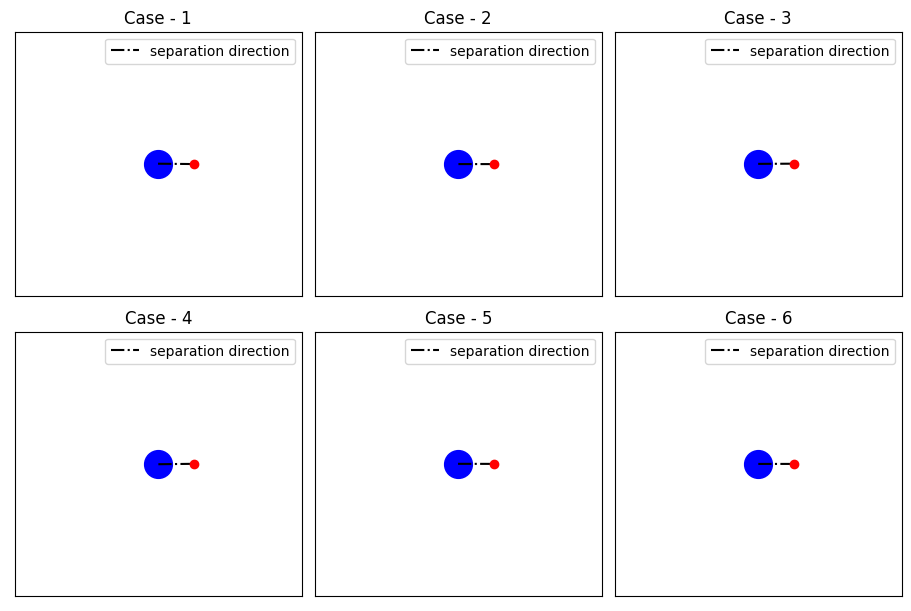

In [11]:
visualize_clocks(settings)

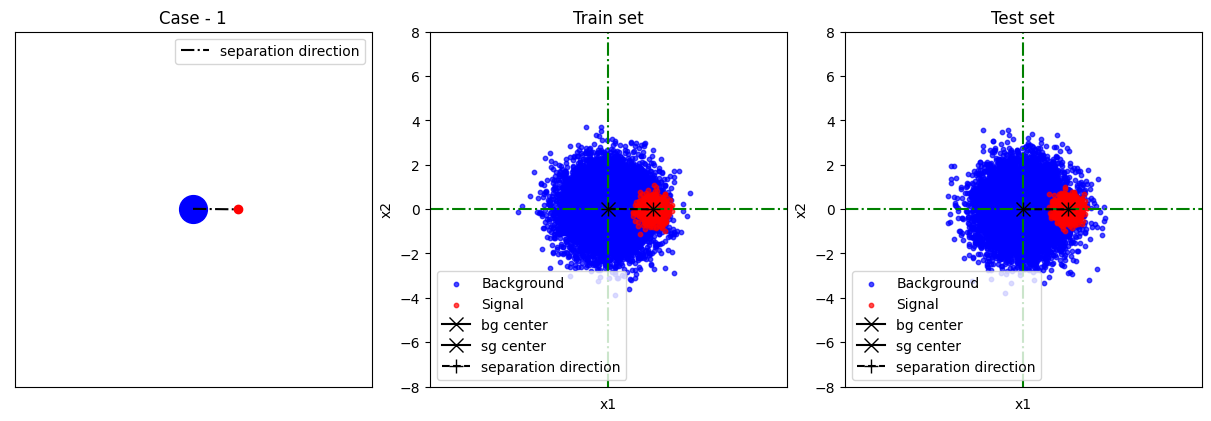

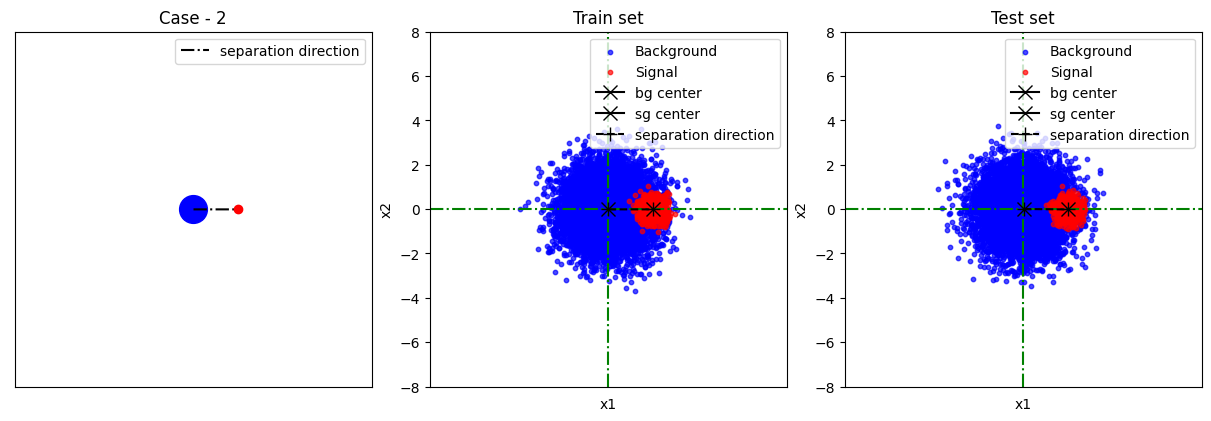

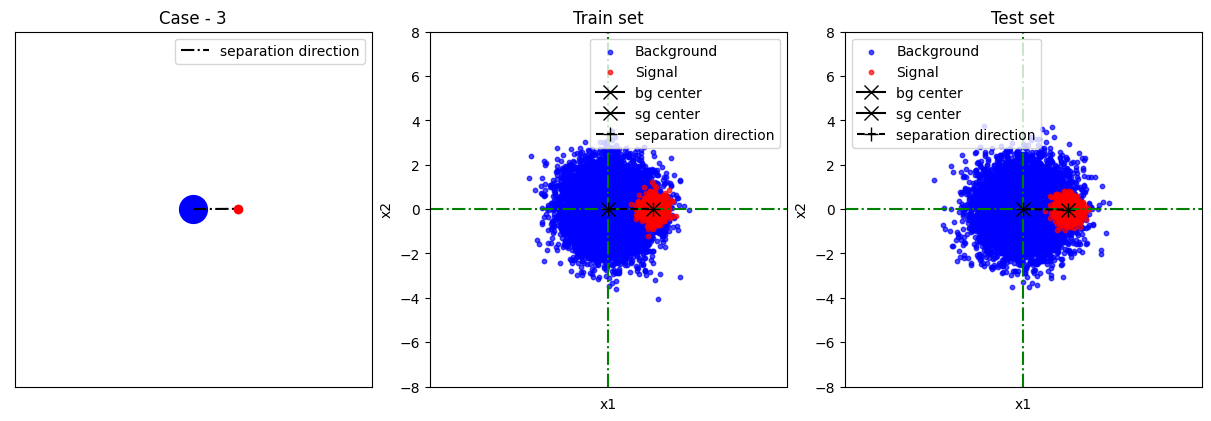

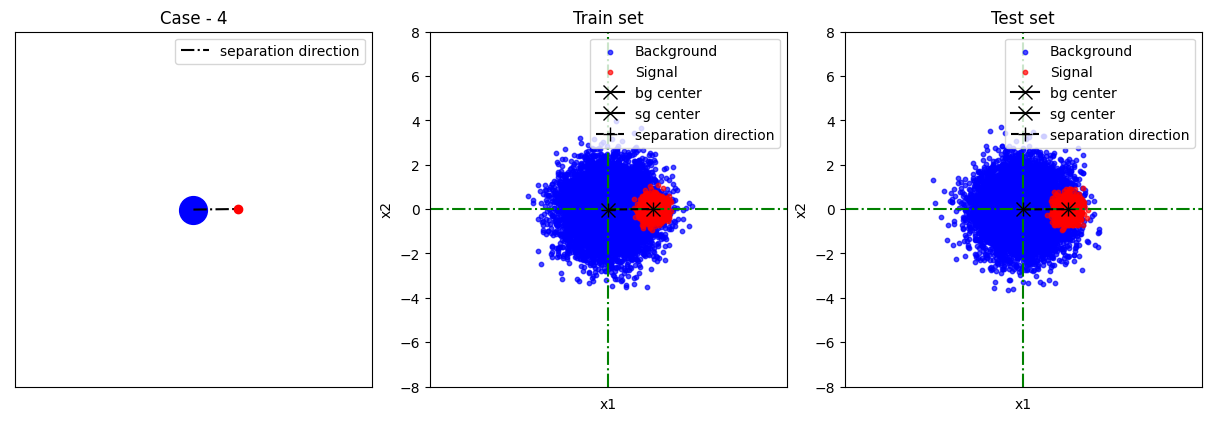

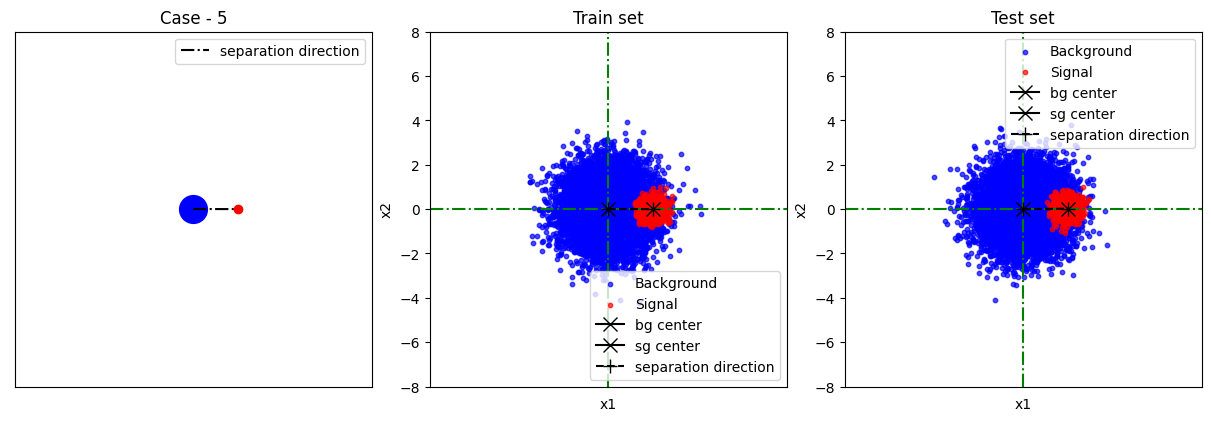

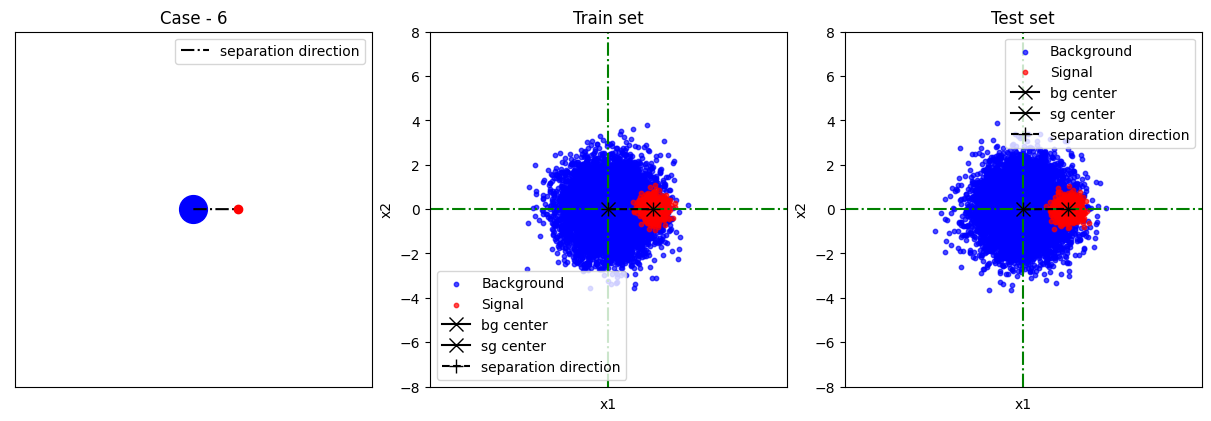

In [12]:
for index, _ in enumerate(train_sets):
    visualize_data(settings[index], train_sets[index], test_sets[index])

***
# 3 - Optimize $\theta$
***

### Initialize caditate $\theta$

In [13]:
theta_candidates = np.arange(-10,3)
theta_candidates

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2])

### Get Train sets (one for each theta) and search for best $\theta$

In [14]:
settings_theata, trains_theta, tests_theta = [], [], []
for i, theta_i in enumerate(theta_candidates):
    # Generate params 
    data_gen_param = Params(pi=0.1,
                             nu_1=10000,
                             mu_range=[0.9, 1.1], 
                             systematics=[],
                             verbose=False)

    # Generate setting from params for data generation
    data_gen_setting = Setting(case=i+1, params=data_gen_param).get_setting()

    # Generate Data
    data_gen = DataGenerator(settings_dict=data_gen_setting)
    data_gen.generate_data()
    setting, train, test = data_gen.get_data()

    settings_theata.append(setting) 
    trains_theta.append(train)
    tests_theta.append(test)

optimizer = Optimizer(
        thetas = theta_candidates,
        train_sets = trains_theta,
        test_sets = tests_theta
    )
optimizer.train()
optimizer.predict()
optimizer.compute_score()
best_theta_result = optimizer.get_best_theta()

	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Compute Scores
	[*] Return Best Theta


In [15]:
best_theta_result

{'theta': -2,
 'score': 0.0012752290155299832,
 'nu_roi': 1504,
 'beta_roi': 418,
 'gamma_roi': 1086}

***
# 4 - Baselines
***

**Model Names and settings**

In [ ]:
model_settings = [
    {
        "display_name": "NB",
        "model_name": "NB",
        "preprocessing" : False,
        "preprocessing_method" : "translation"
    }
]

**Train and Test**  

- Load Data
- Train Model
- Get Predictions
- Get Score
- Get Metric Scores
- Save Predictions
- Save Scores


In [ ]:
trainer = Trainer(
    theta = best_theta_result["theta"],
    model_settings=model_settings,
    result_dir=result_dir,
    model_dir=model_dir,
    train_sets=train_sets,
    test_sets=test_sets,
    settings=settings,
    write=write
)
trainer.train()
train_results = trainer.get_result()

In [ ]:
estimated_mu = train_results[0]["mu_hat"]
np.mean(estimated_mu)

In [ ]:
datasets = [f"Dataset {index+1}" for index in range(0,6)]
plt.bar(datasets,estimated_mu)
plt.axhline(y=1, color='r', linestyle='-.', label="ideal $\mu$")
plt.xlabel("Dataset")
plt.ylabel("$\hat{\mu}$")
plt.title("Estimation of $\hat{\mu}$")
plt.show()

In [ ]:
ground_mu = [p.get_mu() for p in data_gen_params]
plt.scatter(ground_mu, estimated_mu)
plt.xlabel("Ground Truth $\mu$")
plt.ylabel("Predicted $\hat{\mu}$")
plt.title("Estimation of $\hat{\mu}$")
plt.ylim(0.9,1.1)
plt.xlim(0.9,1.1)
plt.show()

In [ ]:
delta_mu = [np.abs(mu.get_mu() - mu_hat) for mu, mu_hat in zip(data_gen_params, estimated_mu)]
plt.plot(delta_mu, marker="x")
plt.title("$\Delta{\mu} = |\hat{\mu} -\mu|$")
plt.ylim(0.9,1.1)
plt.show()

In [ ]:
delta_mu